### Import libraries

In [16]:
#IMPORTING LIBRARIES
import pandas as pd
import openpyxl
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.chart import PieChart, Reference
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt


### Customization

In [17]:
# Customize parameters 
file_path = "0301 Raw data.csv" 
my_allocation_pie="0301 overhead_allocation_pie_chart.png"
my_cost_pool_allocation="0301 overhead_allocation_bar_chart.png"

# Provide the output file names without the extension
my_abc_report = "0301 ABC_Report" 
my_cost_pool_info = "0301 cost_pool_info"
my_cost_driver = "0301 cost_driver_breakdown"

costpools = "cost pools"
totaloverheads = "total overheads"
costdrivers = "cost drivers"
productionvolume = "production volume"
profitbeforeoverheads = "profit before overheads"
currency_symbol = "USD" 

### Develop functions for ABC analysis

In [18]:
# Function to load and clean data

def load_cost_data(file_path):
    df = pd.read_csv(file_path)
    df.dropna(how="all", inplace=True)
    df.columns = df.columns.str.strip().str.casefold()

    # Column validation
    required_columns = {costpools, totaloverheads, costdrivers}
    if not required_columns.issubset(set(df.columns)):
        raise ValueError("CSV format is not supported. Please ensure it contains cost pools, total overheads, and cost drivers.")

    # Removing white spaces 
    df[costpools] = df[costpools].str.strip().str.casefold()
    
    # Extract production volume 
    
    production_volume_row = df[df[costpools] == productionvolume]
    if production_volume_row.empty:
        raise ValueError("Production volume row is missing in CSV.")  
    production_volumes = {
        product: production_volume_row.iloc[0][product]
        for product in df.columns if product not in [costpools, totaloverheads, costdrivers]
    }

    # Extract profit before overhead 
    profit_before_overheads_row = df[df[costpools] == profitbeforeoverheads]
    if profit_before_overheads_row.empty:
        raise ValueError("Profit before overheads row is missing in CSV.")    
    profit_before_overheads = {
        product: profit_before_overheads_row.iloc[0][product]
        for product in df.columns if product not in [costpools, totaloverheads, costdrivers]
    }

    # Removing specific columns.     
    df = df[~df[costpools].isin([productionvolume, profitbeforeoverheads])]

    # Build dictionaries
    
    cost_pools = {
        row[costpools]: {"total_overheads": row[totaloverheads], "cost_drivers": row[costdrivers]}
        for _, row in df.iterrows()
    }

    # Extract product usage     
    product_usage = {
        product: {row[costpools]: row[product] for _, row in df.iterrows()}
        for product in production_volumes.keys()
    }

    return cost_pools, product_usage, production_volumes, profit_before_overheads  

cost_pools, product_usage, production_volumes, profit_before_overheads = load_cost_data(file_path)  


### Cost, allocation, and profit computation 

In [19]:
# Compute cost per activity unit
cost_per_activity = {}
for pool, details in cost_pools.items():
    total_activity = sum(product_usage[product][pool] for product in product_usage)
    cost_per_activity[pool] = details["total_overheads"] / total_activity if total_activity > 0 else 0

# Allocate overhead to products
abc_allocations = {}
for product, activities in product_usage.items():
    abc_allocations[product] = sum(cost_per_activity[pool] * activities[pool] for pool in cost_pools)

total_overhead = sum(abc_allocations.values())

# Calculate profit metrics
profits = {product: profit_before_overheads[product] - abc_allocations[product] for product in product_usage}
total_profit = sum(profits.values())  
profit_percentages = {product: (profits[product] / total_profit) * 100 for product in product_usage}
profit_per_unit = {product: profits[product] / production_volumes[product] for product in product_usage}

### Allocation based on ABC methodology

In [20]:
# Final ABC report 
abc = pd.DataFrame({
    "Product": list(production_volumes.keys()),
    f"Overhead Allocation ({currency_symbol})": [round(abc_allocations[p], 2) for p in product_usage], 
    "% of Total Overhead": [round((abc_allocations[p] / total_overhead) * 100, 2) for p in product_usage], 
    f"Overhead Per Unit ({currency_symbol})": [round(abc_allocations[p] / production_volumes[p], 2) for p in product_usage], 
    f"Profit Before Overheads ({currency_symbol})": [round(profit_before_overheads[p], 2) for p in product_usage],  
    f"Profit ({currency_symbol})": [round(profits[p], 2) for p in product_usage],  
    "Profit %": [round(profit_percentages[p], 2) for p in product_usage],  
    f"Profit per Unit ({currency_symbol})": [round(profit_per_unit[p], 2) for p in product_usage],  
})

# Add total rowa
total_row = pd.DataFrame([[
    "Total",
    round(total_overhead, 2),
    100.00,  
    "-",  
    round(sum(profit_before_overheads.values()), 2), 
    round(total_profit, 2),  
    100.00,  
    "-"  
]], columns=abc.columns)
abc = pd.concat([abc, total_row], ignore_index=True)
abc["Product"] = abc["Product"].str.title()

# Prepare cost pool information table

cost_pool_info = pd.DataFrame([
    {"Cost Pool": pool.title(), "Cost Driver": details["cost_drivers"], "Recovery Rate": round(cost_per_activity[pool], 4)}
    for pool, details in cost_pools.items()
])


### Use of the cost driver 

In [21]:
# Prepare cost driver breakdown table
cost_driver_breakdown = pd.DataFrame(product_usage).T
cost_driver_breakdown.index.name = "Product"
cost_driver_breakdown.reset_index(inplace=True)
cost_driver_breakdown.columns = [col.title() for col in cost_driver_breakdown.columns]

### Display and save chart

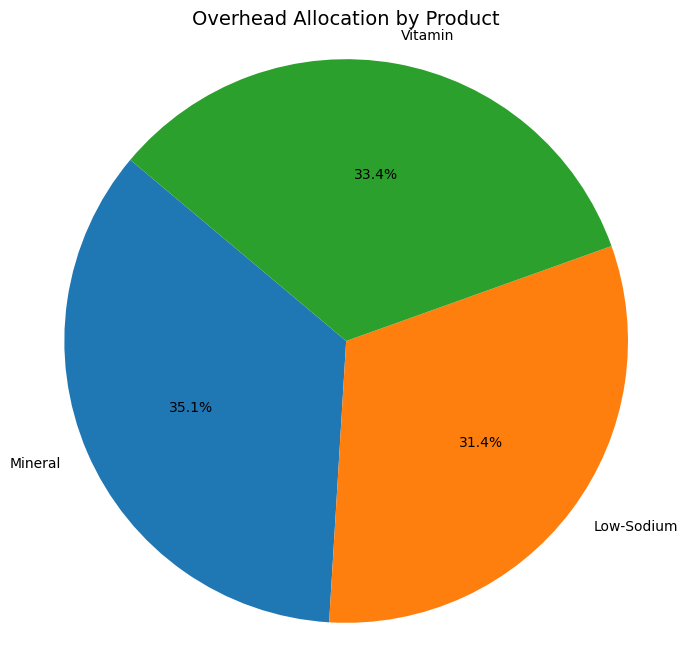

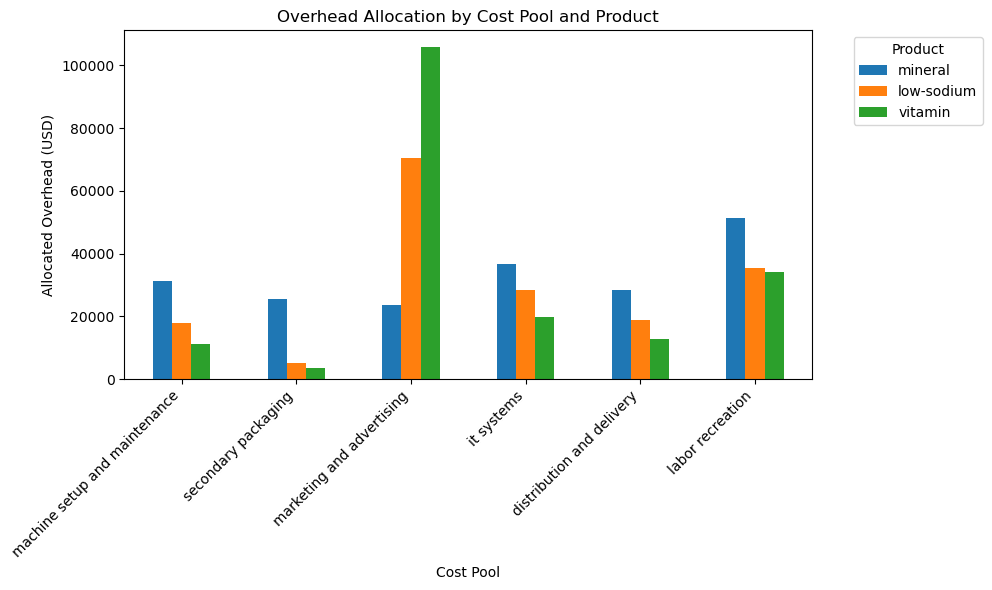

In [22]:
# Extract overhead data (excluding total row)
products = [p for p in abc["Product"] if p.lower() != "total"]
overheads = abc.loc[abc["Product"].str.lower() != "total", f"Overhead Allocation ({currency_symbol})"]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(overheads, labels=products, autopct='%1.1f%%', startangle=140)
plt.title("Overhead Allocation by Product", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular


# Save the pie chart to an image file
plt.savefig(my_allocation_pie, bbox_inches="tight")

# Display the chart in the notebook
plt.show()



# Bar chart: Reconstruct overhead allocation breakdown DataFrame
# Prepare data: Rows = Cost Pools, Columns = Products

overhead_data = {
    pool: {
        product: product_usage[product][pool] * cost_per_activity[pool]
        for product in product_usage
    }
    for pool in cost_pools
}

#  Create DataFrame
df_overhead_breakdown = pd.DataFrame(overhead_data).T  # Rows: Cost Pools, Columns: Products

# Plot grouped bar chart
ax = df_overhead_breakdown.plot(kind="bar", figsize=(10, 6))

plt.title("Overhead Allocation by Cost Pool and Product")
plt.xlabel("Cost Pool")
plt.ylabel(f"Allocated Overhead ({currency_symbol})")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


# Save chart to file
plt.savefig(my_cost_pool_allocation, bbox_inches="tight")

# Show chart in notebook
plt.show()


### Save report in CSV format

In [23]:
# Save CSVs
abc.to_csv(f"{my_abc_report}.csv", index=False)
cost_pool_info.to_csv(f"{my_cost_pool_info}.csv", index=False)
cost_driver_breakdown.to_csv(f"{my_cost_driver}.csv", index=False)

### Save to formatted excel file (Optional)

In [24]:
# SAVE TO EXCEL
my_excel_report=(f"{my_abc_report}_excel.xlsx")
with pd.ExcelWriter(my_excel_report, engine="openpyxl") as writer:
    abc.to_excel(writer, sheet_name="ABC Report", index=False)
    cost_pool_info.to_excel(writer, sheet_name="Cost Pool Info", index=False)
    cost_driver_breakdown.to_excel(writer, sheet_name="Cost Driver Breakdown", index=False)
    
    workbook = writer.book
    worksheet = writer.sheets["ABC Report"]

    # FORMATTING
    bold = Font(bold=True)
    heading_color = PatternFill(start_color="7DA7D9", fill_type="solid")
    content_color = PatternFill(start_color="BFD3E6", fill_type="solid")
    left_align = Alignment(horizontal="left")
    right_align = Alignment(horizontal="right")

    for col_idx, col in enumerate(worksheet.iter_cols(), 1):
        for cell in col:
            cell.alignment = right_align if isinstance(cell.value, (int, float)) or cell.value == "-" else left_align
            if cell.row == 1 or cell.row == worksheet.max_row:
                cell.font = bold
                cell.fill = heading_color
            else:
                cell.fill = content_color

    for col_idx, col in enumerate(worksheet.iter_cols(min_row=2), 1):
        header_value = worksheet.cell(row=1, column=col_idx).value 
        for cell in col:
            if isinstance(cell.value, (int, float)): 
                if header_value and "%" in header_value: 
                    cell.value = cell.value / 100  
                    cell.number_format = '0.00%'  
                else:
                    cell.number_format = '#,##0.00'  

    for col in worksheet.columns:
        max_length = 0
        col_letter = col[0].column_letter    
        for cell in col:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        adjusted_width = max_length + 2  
        worksheet.column_dimensions[col_letter].width = adjusted_width

    thin_side = Side(style="thin")
    for row in worksheet.iter_rows(min_row=1, max_row=worksheet.max_row, min_col=1, max_col=worksheet.max_column):
        for cell in row:
            cell.border = Border(left=thin_side, right=thin_side, top=thin_side, bottom=thin_side)

    # PIE CHARTS
    chart_sheet = workbook.create_sheet(title="Charts")

    def create_pie_chart(sheet, title, col_idx, position):
        pie_chart = PieChart()
        pie_chart.title = title
        labels = Reference(worksheet, min_col=1, min_row=2, max_row=worksheet.max_row - 1)
        data = Reference(worksheet, min_col=col_idx, min_row=1, max_row=worksheet.max_row - 1)
        pie_chart.add_data(data, titles_from_data=True)
        pie_chart.set_categories(labels)
        pie_chart.dataLabels = openpyxl.chart.label.DataLabelList()
        pie_chart.dataLabels.showPercent = True
        pie_chart.dataLabels.numFmt = "0.00%"
        sheet.add_chart(pie_chart, position)

    create_pie_chart(chart_sheet, "Overhead Allocation Breakdown", 2, "A1")
    create_pie_chart(chart_sheet, "Overhead Per Unit", 4, "A17")
    create_pie_chart(chart_sheet, "Profit Per Unit", 7, "J17")

    workbook.save(my_excel_report)

print ("File save status:")
print (f"The main report has been saved as {my_abc_report}.csv" )
print (f"The cost pool report has been saved as {my_cost_pool_info}.csv" )
print (f"The cost driver report has been saved as {my_cost_driver}.csv" )
print(f"Your formatted  report has been successfully created and saved to {my_excel_report}")


File save status:
The main report has been saved as 0301 ABC_Report.csv
The cost pool report has been saved as 0301 cost_pool_info.csv
The cost driver report has been saved as 0301 cost_driver_breakdown.csv
Your formatted  report has been successfully created and saved to 0301 ABC_Report_excel.xlsx
